In [1]:
import warnings
import src
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from pathlib import Path

warnings.filterwarnings("ignore")

/home/chia/miniconda3/envs/unet/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
model = smp.UnetSiamese(
    classes=4,
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    activation=None,
    decoder_attention_type="scse",
)

In [ ]:
x = torch.rand(1, 6, 256, 256)
loc, dmg = model(x)

print(loc.shape, dmg.shape)

y = torch.sum(x, dim=1)
y = (y  != 0)
print(y.shape)  

torch.Size([1, 1, 256, 256]) torch.Size([1, 4, 256, 256])
torch.Size([1, 256, 256])


In [4]:
data_dir = "/home/bruno/Dropbox/DATASETS/dfc25_track2_trainval/train"
fn_list = [f for f in Path(data_dir).rglob("*.tif") if "post-event" in str(f)]

datloader = src.dataset.DFC25(fn_list, classes=[0, 1, 2, 3])

(1024, 1024) 0.0 0.0
(1024, 1024) 0.0 1.0
(1024, 1024) 0.0 1.0
(1024, 1024) 0.0 1.0
(1024, 1024) 0.0 1.0


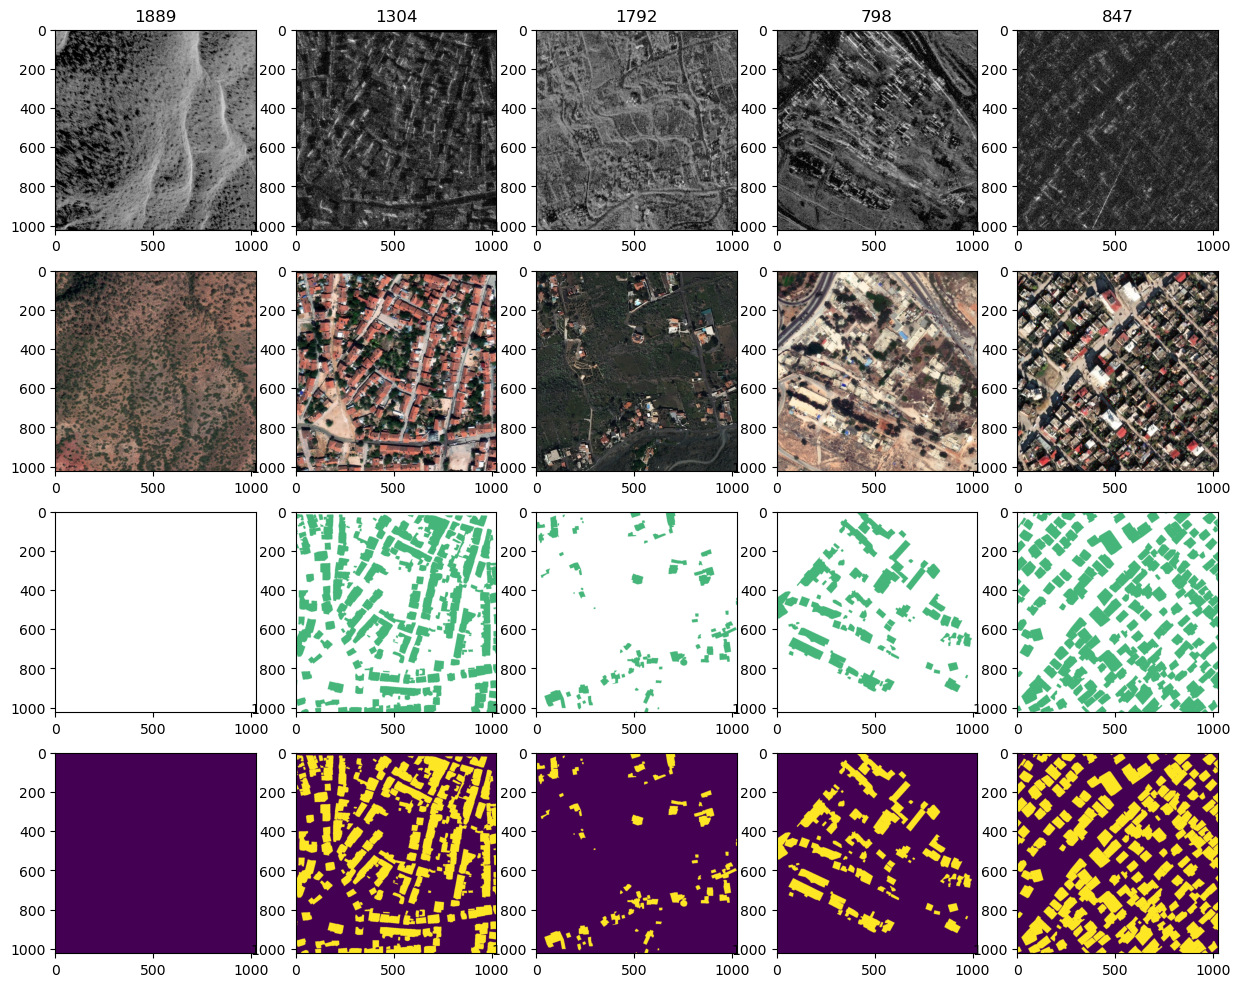

In [6]:
# ---------------------
# Read and plot samples
# ---------------------
nplot = 5
idxs = np.argsort(np.random.rand(len(fn_list)))[:nplot]
fig, axs = plt.subplots(4, nplot, figsize=(nplot*3, 4*3))
for i, idx in enumerate(idxs):
    sar, rgb, gtd, msk, fn = datloader[idx]
    
    sar = np.moveaxis(sar.numpy(), 0, -1)
    rgb = np.moveaxis(rgb.numpy(), 0, -1)
    gtd2 = src.tools.make_rgb(np.argmax(gtd.numpy(), axis=0))
    msk = msk.numpy()

    # msk = (torch.argmax(gtd, dim=0) != 0) * 1.0
    print(msk.shape, msk.min(), msk.max())

    axs[0, i].set_title(idx)
    axs[0, i].imshow(sar, cmap="gray")
    axs[1, i].imshow(rgb)
    axs[2, i].imshow(gtd2)
    axs[3, i].imshow(msk)

plt.show()

In [4]:
# ---------------------
# Check augmentations
# ---------------------
datloader_augm = src.dataset.DFC25(fn_list, augm=src.transforms.train_augm_comp)

/home/bruno/apps/miniconda311/envs/pcc/lib/python3.11/site-packages/pydantic/main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=..., 0.11764705882352941)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


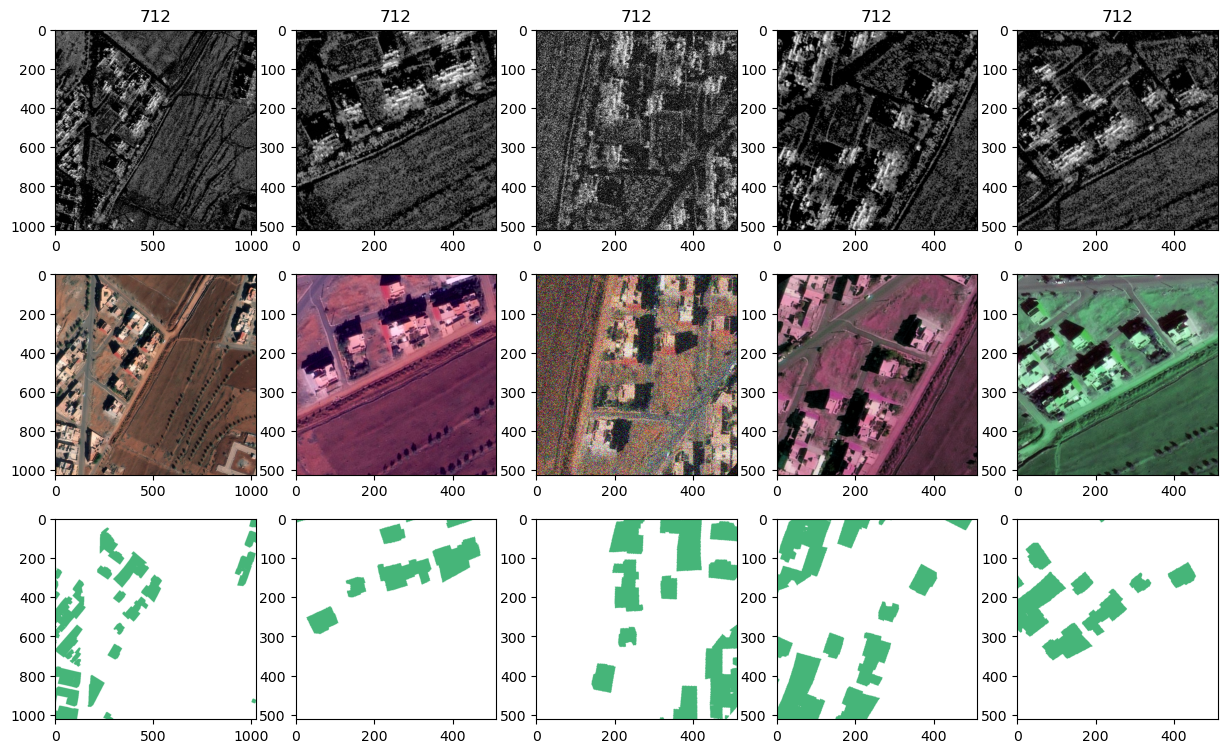

In [5]:
idx = np.argsort(np.random.rand(len(fn_list)))[0]
nplot = 5

fig, axs = plt.subplots(3, nplot, figsize=(nplot*3, 3*3))
sar, rgb, gtd, fn = datloader[idx]

sar = np.moveaxis(sar.numpy(), 0, -1)
rgb = np.moveaxis(rgb.numpy(), 0, -1)
gtd = src.tools.make_rgb(np.argmax(gtd.numpy(), axis=0))

axs[0, 0].set_title(idx)
axs[0, 0].imshow(sar, cmap="gray")
axs[1, 0].imshow(rgb)
axs[2, 0].imshow(gtd)

for i in range(1, nplot):
    sar, rgb, gtd, fn = datloader_augm[idx]

    sar = np.moveaxis(sar.numpy(), 0, -1)
    rgb = np.moveaxis(rgb.numpy(), 0, -1)
    gtd = src.tools.make_rgb(np.argmax(gtd.numpy(), axis=0))

    axs[0, i].set_title(idx)
    axs[0, i].imshow(sar[:, :, 0], cmap="gray")
    axs[1, i].imshow(rgb)
    axs[2, i].imshow(gtd)
plt.show()

In [8]:
# ---------------------
# Make Predictions
# ---------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

# model = smp.UnetSiamese(
#         classes=len(CLASSES),
#         encoder_name="efficientnet-b4",
#         encoder_weights="imagenet",
#         # in_channels=6,  ##added by chia
#         activation=None,
#         decoder_attention_type="scse",
#     )

# model = smp.SegformerSiamese(
model = smp.UnetSiamese(
    classes=4,
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    activation=None,
    decoder_attention_type="scse",
)
# checkpoint = "weights/segformersiamese-efficientnet-b4_b10_e100_s200_jaccardmccfocal.pth"
checkpoint = "/home/chia/bdd_multimodal-main/weights_unet/unetsiamese-efficientnet-b4_b6_e150_s200_bceloss_jaccardmccweighted.pth"
model, *_ = src.utils.load_checkpoint(checkpoint, model, verbose=True)
model = model.eval().to(device)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [15]:

# Set device to GPU
device = torch.device("cuda")

model = smp.UnetSiamese(
    classes=4,  # Ensure this matches the trained model
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    activation=None,
    decoder_attention_type="scse",
)

checkpoint_path = "/home/chia/bdd_multimodal-main/weights_unet/unetsiamese-efficientnet-b4_b6_e150_s200_bceloss_jaccardmccweighted.pth"
checkpoint = torch.load(checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint["state_dict"])

model = model.to(device).eval()

print("Model loaded successfully and ready for inference!")



Model loaded successfully and ready for inference!


In [22]:
dataset = "val"
data_dir = f"/home/chia/bdd_multimodal-main/BDD_dataset/{dataset}"
fn_list = [f for f in Path(data_dir).rglob("*.tif") if "post_disaster" in str(f)]

# fn_list = [f for f in Path(data_dir).rglob("*.tif") if "post-event" in str(f)]

print(f"Making predictions on {len(fn_list)} samples, using {dataset}")

Making predictions on 118 samples, using val


/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00031_post_disaster_sar.tif


RuntimeError: Given groups=1, weight of size [48, 3, 3, 3], expected input[4, 1, 513, 513] to have 3 channels, but got 1 channels instead

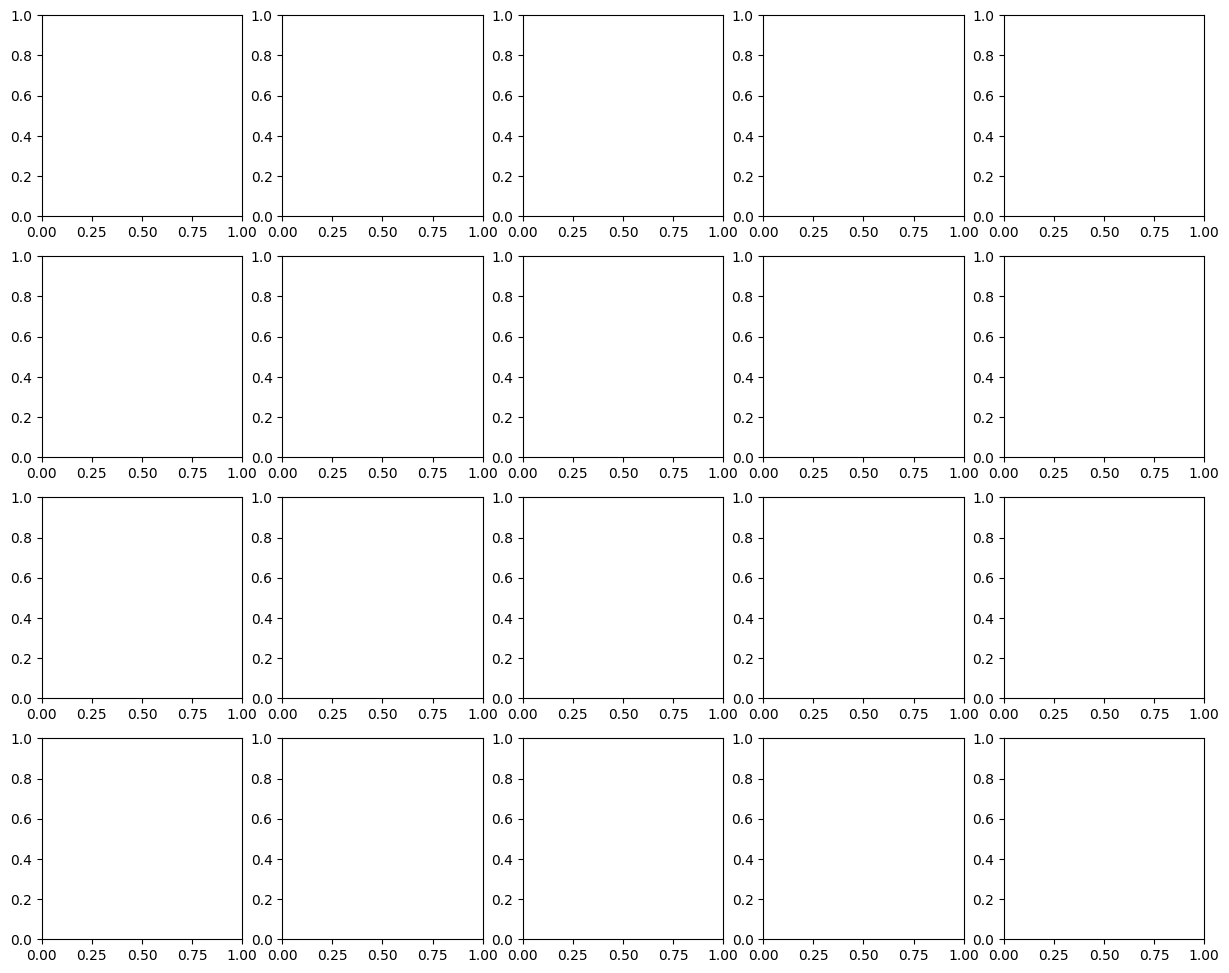

In [19]:
# ---------------------
# Read and plot samples
# ---------------------
nplot = 5
idxs = np.argsort(np.random.rand(len(fn_list)))[:nplot]
fig, axs = plt.subplots(4, nplot, figsize=(nplot*3, 4*3))

for i, idx in enumerate(idxs):

    print(fn_list[idx])

    sar = src.dataset.load_grayscale(fn_list[idx])
    rgb = src.dataset.load_multiband(str(fn_list[idx]).replace("post-event", "pre-event").replace("post_disaster", "pre_disaster"))

    if dataset != "val":
        gtd = src.dataset.load_grayscale(str(fn_list[idx]).replace("post-event", "target").replace("post_disaster", "building_damage"))
        gtd = src.tools.make_rgb(gtd)
    else:
        gtd = np.zeros_like(sar)

    img = np.moveaxis(np.concatenate([np.stack([sar, sar, sar], axis=-1), rgb], axis=-1), -1, 0) / 255.0

    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, :, ::-1].copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[:, ::-1, ::-1].copy())
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in imgs], dim=0).float().to(device)

    pred = []
    with torch.no_grad():
        *_, msk = model.forward(tensor)
        msk = torch.softmax(msk[:, :, ...], dim=1).cpu().numpy()
        pred.append(msk[0, :, :, :])
        pred.append(msk[1, :, :, ::-1])
        pred.append(msk[2, :, ::-1, :])
        pred.append(msk[3, :, ::-1, ::-1])        

    # --- mean version ---
    pred = np.asarray(pred).mean(axis=0).argmax(axis=0)

    axs[0, i].set_title(idx)
    axs[0, i].imshow(sar, cmap="gray")
    axs[1, i].imshow(rgb)
    axs[2, i].imshow(gtd)
    axs[3, i].imshow(src.tools.make_rgb(pred))
plt.show()



/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00025_post_disaster_sar.tif


RuntimeError: Given groups=1, weight of size [48, 3, 3, 3], expected input[4, 1, 513, 513] to have 3 channels, but got 1 channels instead

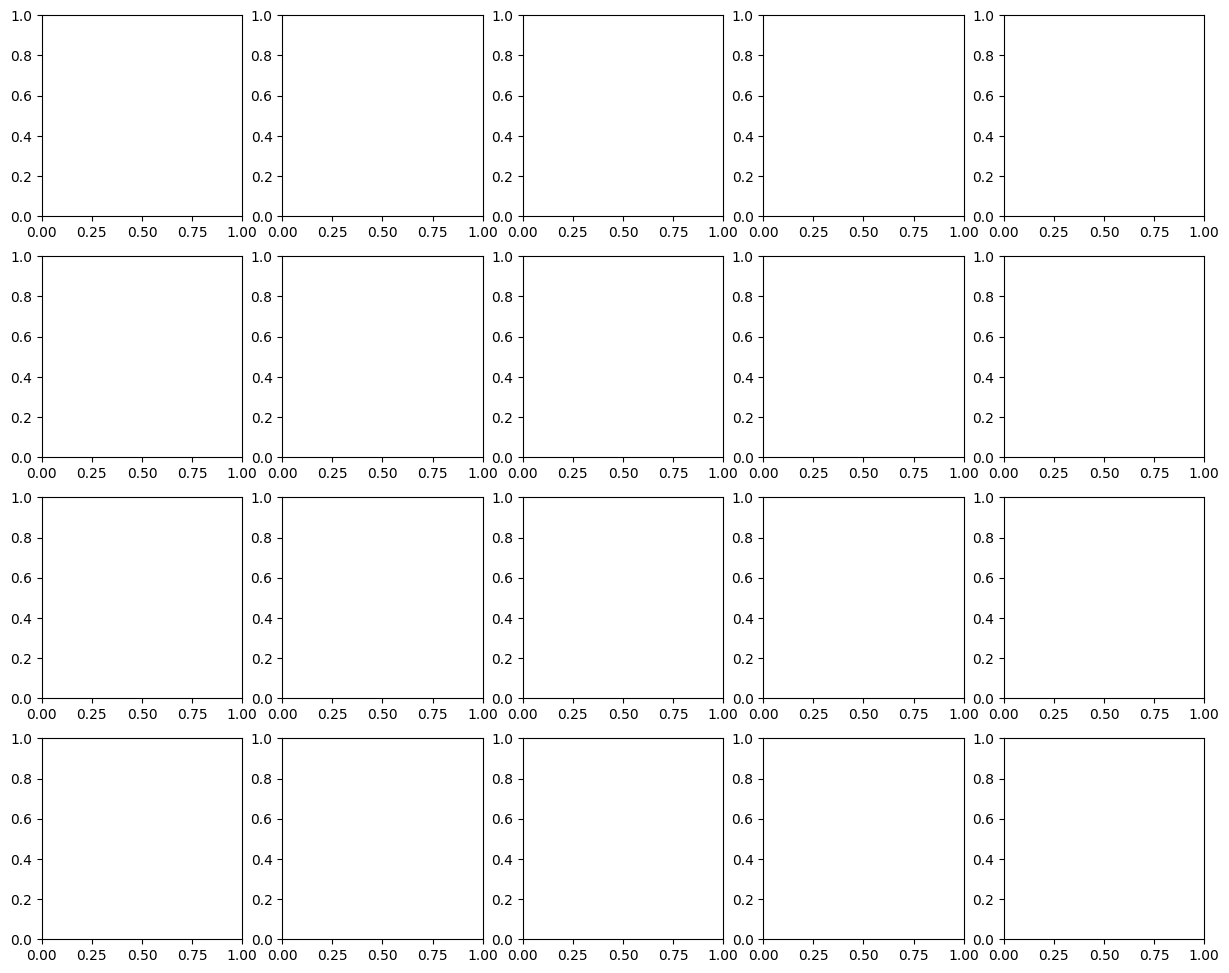

In [20]:
nplot = 5
idxs = np.argsort(np.random.rand(len(fn_list)))[:nplot]
fig, axs = plt.subplots(4, nplot, figsize=(nplot*3, 4*3))



for i, idx in enumerate(idxs):
    print(fn_list[idx])
    sar = src.dataset.load_grayscale(fn_list[idx])
    rgb = src.dataset.load_multiband(str(fn_list[idx]).replace("post-event", "pre-event").replace("post_disaster", "pre_disaster"))
    
    if dataset != "val":
        gtd = src.dataset.load_grayscale(str(fn_list[idx]).replace("post-event", "target").replace("post_disaster", "building_damage"))
        gtd = src.tools.make_rgb(gtd)
    else:
        gtd = np.zeros_like(sar)
    
    img = np.moveaxis(np.concatenate([np.stack([sar, sar, sar], axis=-1), rgb], axis=-1), -1, 0) / 255.0

    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, :, ::-1].copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[:, ::-1, ::-1].copy())
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in imgs], dim=0).float().to(device)
    
    pred = []
    with torch.no_grad():
        *_, msk = model.forward(tensor)
        msk = torch.softmax(msk[:, :, ...], dim=1).cpu().numpy()
        pred.append(msk[0, :, :, :])
        pred.append(msk[1, :, :, ::-1])
        pred.append(msk[2, :, ::-1, :])
        pred.append(msk[3, :, ::-1, ::-1])
        
    # --- mean version ---
    pred = np.asarray(pred).mean(axis=0).argmax(axis=0)

    axs[0, i].set_title(idx)
    axs[0, i].imshow(sar, cmap="gray")
    axs[1, i].imshow(rgb)
    axs[2, i].imshow(gtd)
    axs[3, i].imshow(src.tools.make_rgb(pred))
plt.show()


In [36]:
fn_list

[PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00232_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/haiti-earthquake_00003_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00198_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00185_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00026_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00202_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00165_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00192_post_disaster_sar.tif'),
 PosixPath('/home/chia/bdd_multi

In [44]:
gtd_path

'/home/chia/bdd_multimodal-main/BDD_dataset/val/building_damage/philippines-typhoon_00100_building_damage.tif'

Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00275_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00032_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00053_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00049_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00048_post_disaster_sar.tif


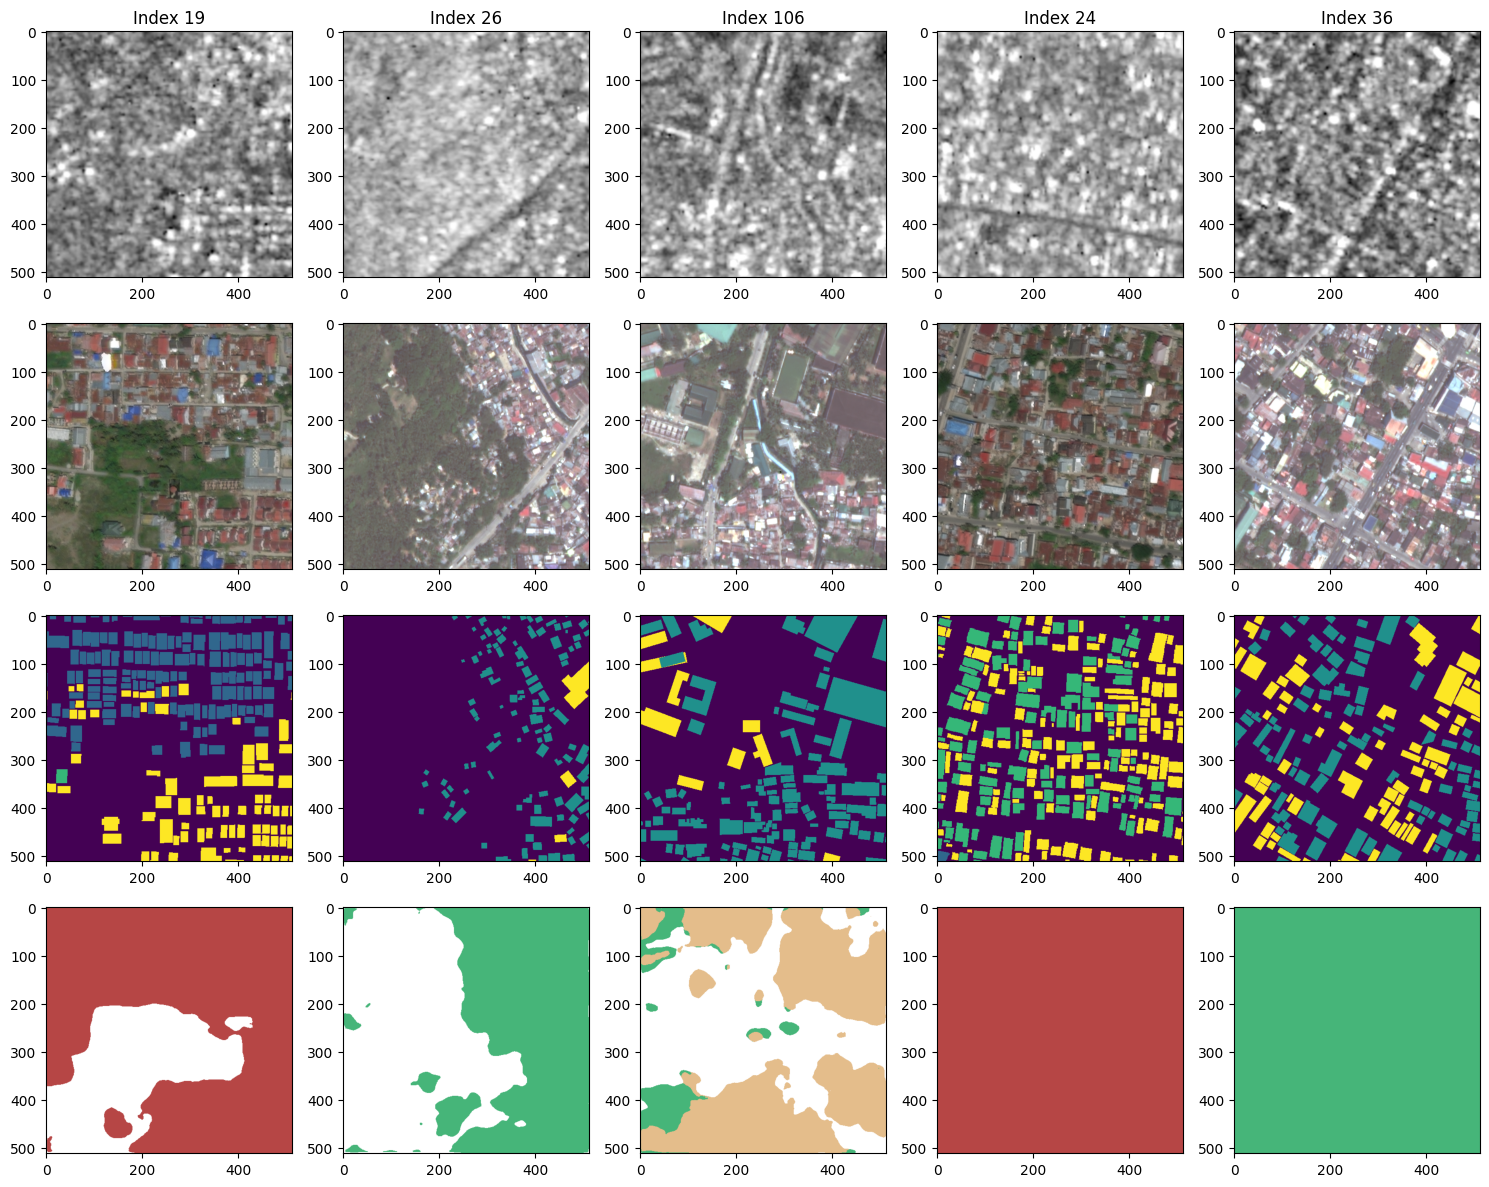

In [48]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import src.dataset   # Assuming your dataset functions are here
import src.tools     # For make_rgb or similar functions

# Number of samples to plot
nplot = 5
# Randomly select nplot indices
idxs = np.random.choice(len(fn_list), nplot, replace=False)
fig, axs = plt.subplots(4, nplot, figsize=(nplot * 3, 4 * 3))

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using the same logic as in BDD3 ---
    # Load post-disaster SAR (grayscale)
    sar = src.dataset.load_grayscale(fn_list[idx])
    # Load pre-disaster Optical:
    optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_pre_disaster_sar.tif", "_pre_disaster.tif") ### optical
    optical = src.dataset.load_multiband(optical_path)
    # Load pre-disaster SAR:
    presar_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_post_disaster_sar", "_pre_disaster_sar")
    pre_sar = src.dataset.load_grayscale(presar_path)
    
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    
    # # (Optional) Load ground truth if available for visualization:
    # if dataset != "val":
    #     gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    #     gtd = src.dataset.load_grayscale(gtd_path)
    # else:
    #     gtd = np.zeros_like(sar)
    
    # --- Preprocess and Fuse ---
    # Convert SAR (post) to a 3-channel image
    sar_3ch = np.stack([sar, sar, sar], axis=-1)  # shape: (H, W, 3)
    # Assume optical is already a 3-channel image; if not, adjust accordingly.
    # Convert pre-disaster SAR to 3-channel:
    pre_sar_3ch = np.stack([pre_sar, pre_sar, pre_sar], axis=-1)
    # Fuse the two pre-disaster modalities by averaging
    fused_pre = (optical.astype(np.float32) + pre_sar_3ch.astype(np.float32)) / 2.0
    # Ensure the fused image is in the same range as the others.
    
    # Create a 6-channel image by concatenating post-disaster SAR and the fused pre-disaster image.
    # They should both be of shape (H, W, 3); concatenation along the channel axis (axis=-1) gives (H, W, 6)
    input_img = np.concatenate([sar_3ch, fused_pre], axis=-1)
    # Rearrange to channel-first order: (6, H, W)
    input_img = np.moveaxis(input_img, -1, 0) / 255.0  # normalize to [0, 1]
    
    # --- Test-Time Augmentation (Optional) ---
    # Here we create flipped versions for TTA
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())     # horizontal flip
    tta_imgs.append(input_img[:, ::-1, :].copy())     # vertical flip
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())    # both flips
    
    # Convert to torch tensors and stack into a batch
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        # Assuming your model returns two outputs: localization and segmentation;
        # Here we use the segmentation output (typically the second one)
        loc_out, seg_out = model(tensor)
        # Compute probabilities with softmax along the channel dimension
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        # Collect TTA predictions: For instance, assume the batch dimension corresponds to different flips.
        preds = []
        # If your TTA ordering is the same as above:
        preds.append(seg_prob[0])  # original
        preds.append(seg_prob[1][:, :, ::-1])  # reverse horizontal flip
        preds.append(seg_prob[2][:, ::-1, :])  # reverse vertical flip
        preds.append(seg_prob[3][:, ::-1, ::-1])  # reverse both
        
        # Average the predictions across TTA and then take the argmax to get class labels.
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # --- Plotting ---
    axs[0, i].set_title(f"Index {idx}")
    axs[0, i].imshow(sar, cmap="gray")
    axs[1, i].imshow(optical.astype(np.uint8))
    axs[2, i].imshow(gtd, cmap="viridis" )  # or use src.tools.make_rgb(gtd) if needed
    axs[3, i].imshow(src.tools.make_rgb(final_pred))  # visualize predicted segmentation map

plt.tight_layout()
plt.show()
